In [1]:
import pandas as pd 
import matplotlib. pyplot as plt 
import seaborn as sns
from matplotlib import style 
style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch


/home/luo/anaconda3/envs/mdd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("/home/luo/projects/MDD/data/depress twitter Korean/depress_twitter_Korean.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [4]:
def data_preprocessing (text):
    if isinstance(text, float):
        text=''

    text = text.lower()
    text = re.sub(r"http\s+|www\S+http\S+", "",text,flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub("user",'',text)
    text = re.sub("url",'',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [5]:
df.text = df["tweet"].apply(data_preprocessing)
df.head()

/tmp/ipykernel_3449823/1806502255.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.text = df["tweet"].apply(data_preprocessing)


,tweet,label
0,별이야!!!!!! https://t.co/0ayXZJeew1,0
1,아아아아아ㅏ아아ㅏ\n피곤한데 오랜만에 틧터하면서 밤 샐래\n같이 하실 분? 없으면 ...,1
2,바둑아!!\n개자쓱아 경인선 갔으면 화끈하게~마~\n백신 마자쁘라\n쪽팔리게스루 뭔...,1
3,"외롭다,,,누가 나한테 고백 좀 해주시와요\n#트친소 #게친소 #게이들 https:...",1
4,갑자기업노말재탕중 역시마음의고향이에 https://t.co/5pvwPLEnaN,0


<Axes: xlabel='label', ylabel='count'>

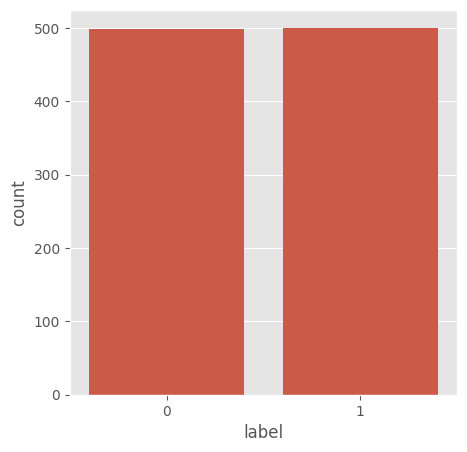

In [6]:

df.text = df["tweet"].apply(data_preprocessing)
df = df.drop_duplicates('tweet')
df['label'].value_counts()
fig = plt.figure(figsize=(5,5))
sns.countplot(x = 'label', data=df)

In [7]:
import numpy as np

In [11]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import softmax

# Load tokenizer and model
MODEL = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)



# Create lists to store predictions and true labels
predicted_labels = []
true_labels = df['label'].tolist()  # Assuming 'true_label' is the column name for true labels

# Inspect the model to find the number of labels it predicts
num_labels = model.config.num_labels

# Define the label mapping (assuming 0: 'not depression', 1: 'depression')
# Adjust this mapping if your model uses different indices
labels = {i: i for i in range(num_labels)}

# Iterate through the DataFrame and make predictions
for index, row in df.iterrows():
    text = row['tweet']
    true_label = row['label']

    # Tokenize and make predictions
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    output = model(**encoded_input)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)

    # Get predicted label
    predicted_label_index = np.argmax(scores)
    predicted_label = labels[predicted_label_index]

    # Store predicted labels
    predicted_labels.append(predicted_label)

# Add the predicted labels to the DataFrame
df['predicted_sentiment'] = predicted_labels

# Calculate accuracy and F1 score
cm = classification_report(true_labels,predicted_labels)
print(cm)


c:\Users\xingr\miniconda3\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\xingr\.cache\huggingface\hub\models--lxyuan--distilbert-base-multilingual-cased-sentiments-student. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


              precision    recall  f1-score   support

           0       0.48      0.64      0.55       500
           1       0.00      0.00      0.00       487
           2       0.00      0.00      0.00         0

    accuracy                           0.33       987
   macro avg       0.16      0.21      0.18       987
weighted avg       0.24      0.33      0.28       987



c:\Users\xingr\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\xingr\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\xingr\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
from deep_translator import GoogleTranslator


In [10]:
def translate_text(text):
    translated_text = GoogleTranslator(source='auto', target='en').translate(text)
    return translated_text

# Apply translation to the "tweet" column and create a new column "translated"
df['translated'] = df['tweet'].apply(translate_text)

# Display the DataFrame with the translated column
print(df.head())
df.to_csv("/home/luo/projects/MDD/data/depress twitter Korean/depress_twitter_Korean_en.csv")

                                               tweet  label  \
0                  별이야!!!!!! https://t.co/0ayXZJeew1      0   
1  아아아아아ㅏ아아ㅏ\n피곤한데 오랜만에 틧터하면서 밤 샐래\n같이 하실 분? 없으면 ...      1   
2  바둑아!!\n개자쓱아 경인선 갔으면 화끈하게~마~\n백신 마자쁘라\n쪽팔리게스루 뭔...      1   
3  외롭다,,,누가 나한테 고백 좀 해주시와요\n#트친소 #게친소 #게이들 https:...      1   
4        갑자기업노말재탕중 역시마음의고향이에 https://t.co/5pvwPLEnaN      0   

                                          translated  
0         It's a star!!!!!!! https://t.co/0ayXZJeew1  
1  Ahhhhhhh\nI'm tired, but it's been a while sin...  
2  Baduk-ah!!\nIf you go to the Gyeongin Line, yo...  
3  I'm lonely,,,someone please confess to me\n#tc...  
4  Suddenly, I'm rehashing the normal version of ...  


In [11]:
import numpy as np

from scipy.special import softmax

In [12]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import softmax

# Load tokenizer and model
MODEL = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Load the dataset

# Create lists to store predictions and true labels
predicted_labels = []
true_labels = df['label'].tolist()  # Assuming 'true_label' is the column name for true labels

# Inspect the model to find the number of labels it predicts
num_labels = model.config.num_labels

# Define the label mapping (assuming 0: 'not depression', 1: 'depression')
# Adjust this mapping if your model uses different indices
labels = {i: i for i in range(num_labels)}

# Iterate through the DataFrame and make predictions
for index, row in df.iterrows():
    text = row['translated']
    true_label = row['label']

    # Tokenize and make predictions
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    output = model(**encoded_input)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)

    # Get predicted label
    predicted_label_index = np.argmax(scores)
    predicted_label = labels[predicted_label_index]

    # Store predicted labels
    predicted_labels.append(predicted_label)

# Add the predicted labels to the DataFrame
df['predicted_sentiment'] = predicted_labels

# Calculate accuracy and F1 score
cm = classification_report(true_labels,predicted_labels)
print(cm)


/home/luo/anaconda3/envs/mdd/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.38      0.39      0.39       499
           1       0.37      0.36      0.37       500

    accuracy                           0.38       999
   macro avg       0.38      0.38      0.38       999
weighted avg       0.38      0.38      0.38       999



binary ： https://huggingface.co/siebert/sentiment-roberta-large-english